In [12]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os
import glob
import mplniw.utils as ut
import mplniw.plot as pl
from scipy import signal
#import mitequinox.sigp as sp


In [13]:
root_dir = '/Users/zcasparcohen/Documents/NISKINE/data/'

In [14]:
def convolve(x, h=None, hilbert=False):
    """ Convolve an input signal with a kernel
    Optionaly compute the Hilbert transform of the resulting time series
    
    Parameters
    x : input signal
    h : filter 
    hilbert : True for Hilbert transform to be applied to the filtered signal
    
    Returns
    x_f : filtered signal or hilbert transform of the filtered signal
    """
    #x_c = np.nan_to_num(x,0)
    #argnan = np.where(np.isnan(x))
    x_c = x.copy()
    x_fill = np.nan_to_num(x_c)
    argnan = np.where(np.isnan(x_c)==True)
    x_f = signal.filtfilt(h, [1], x_fill, axis=-1,padlen=0)#
    x_f[argnan]=np.nan
    if hilbert:
        return signal.hilbert(x_f)
    else:
        return x_f

def filt(v, h, hilbert=False):
    
    output_dtype = complex if hilbert else float
    gufunc_kwargs = dict(output_sizes={'time': len(v.time)})
    return xr.apply_ufunc(convolve, v, kwargs={'h': h, 'hilbert': hilbert},
                    dask='parallelized', output_dtypes=[output_dtype],
                    input_core_dims=[['time']],
                    output_core_dims=[['time']],
                    dask_gufunc_kwargs = gufunc_kwargs,
                         )
def wrap_filter(ds,h):
    ds_copy = ds.copy()
    for v in ['u','v']:
        ds_copy[v+'_ni'] = filt(ds[v],h)
    return ds_copy

In [15]:
mooring='M1'
ds_locations = xr.open_dataset(root_dir+'niskine_mooring_locations.nc')
#ds_gridded = xr.open_dataset(root_dir+'gridded/'+mooring+'_gridded_simple_merge_gaps_filled.nc')

ds_gridded = xr.open_dataset(root_dir+'linear_merge_linear_gaps.nc')
ds_gridded_cubic = xr.open_dataset(root_dir+'linear_merge_cubic_gaps.nc')

In [16]:
lat = ds_locations.sel(mooring=1).lat_actual.values
f = ut.coriolis(lat)
fcpd = f*3600*24/(2*np.pi)
Tw = 40
dband = 0.1
dt = 1/(24*6)

In [17]:
#om,Tw,dband,V = omega,Tw,dband,V #define parameters needed in wrap_filter
h = ut.generate_filter(fcpd, T=Tw, dt=dt, lat=lat, bandwidth=dband, normalized_bandwidth=None)
h_hat, w = ut.filter_response(h, dt=dt)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


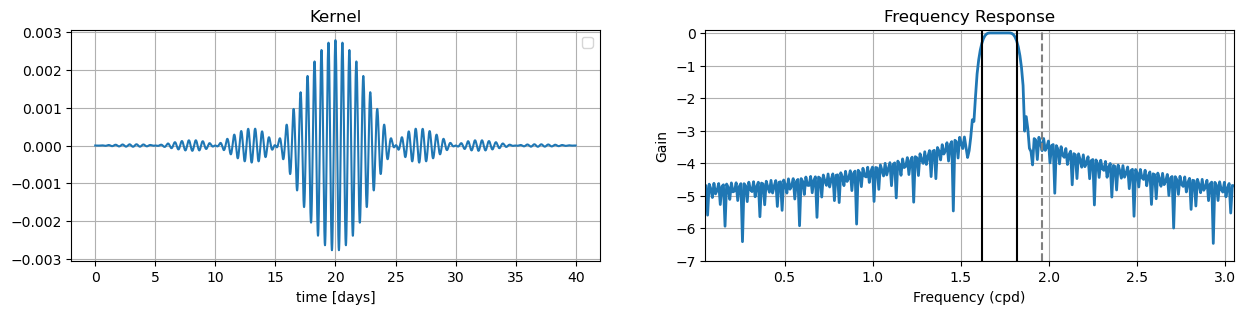

In [18]:
t = np.arange(0,Tw,dt)
fig, axes = plt.subplots(1,2, figsize=(15,3))
ax = axes[0]
ax.plot(t, h)
ax.grid()
ax.set_xlabel('time [days]')
ax.set_title('Kernel')
ax.legend()

ax = axes[1]

ax.plot(w, np.log10(abs(h_hat)), linewidth=2)
ax.axvline(fcpd-dband, color='k')
ax.axvline(fcpd+dband, color='k')
ax.axvline(1.96, color='grey', ls='--')
ax.set_xlabel('Frequency (cpd)')
ax.set_ylabel('Gain')
ax.set_title('Frequency Response')
#ax.set_ylim(-0.05, 1.05)
ax.set_ylim(-7, 0.1)
ax.set_xlim(0.05, 3.05)
ax.grid(True)

In [19]:
ds = wrap_filter(ds_gridded,h)
ds_cubic = wrap_filter(ds_gridded_cubic,h)

In [20]:
ds['ke'] = 0.5*(ds.u**2+ds.v**2)
ds['ke_ni'] = 0.5*(ds.u_ni**2+ds.v_ni**2)

ds_cubic['ke'] = 0.5*(ds.u**2+ds.v**2)
ds_cubic['ke_ni'] = 0.5*(ds.u_ni**2+ds.v_ni**2)

In [24]:
ds_cubic.to_netcdf(root_dir+'filtered_convolve_cubic.nc')

In [26]:
root_dir

'/Users/zcasparcohen/Documents/NISKINE/data/'

(<Figure size 1200x500 with 4 Axes>, <Axes: xlabel='time', ylabel='depth [m]'>)

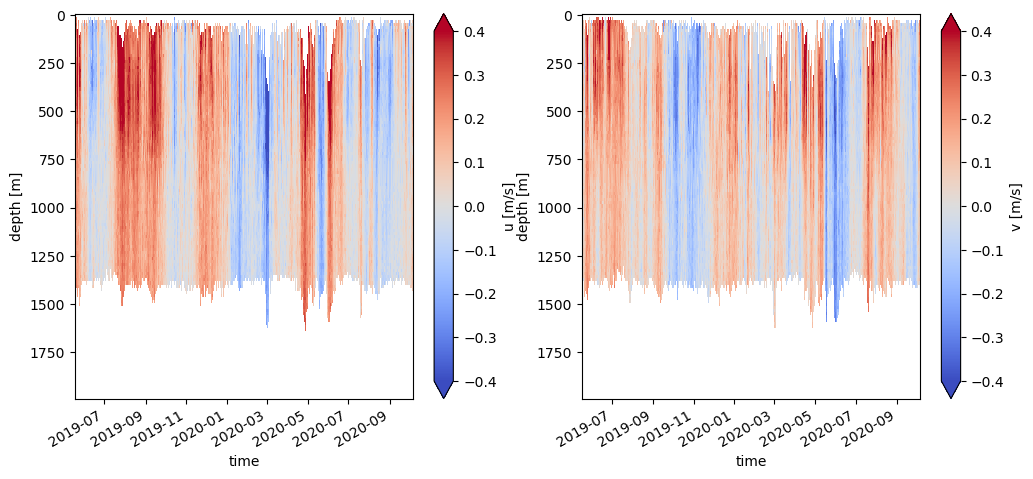

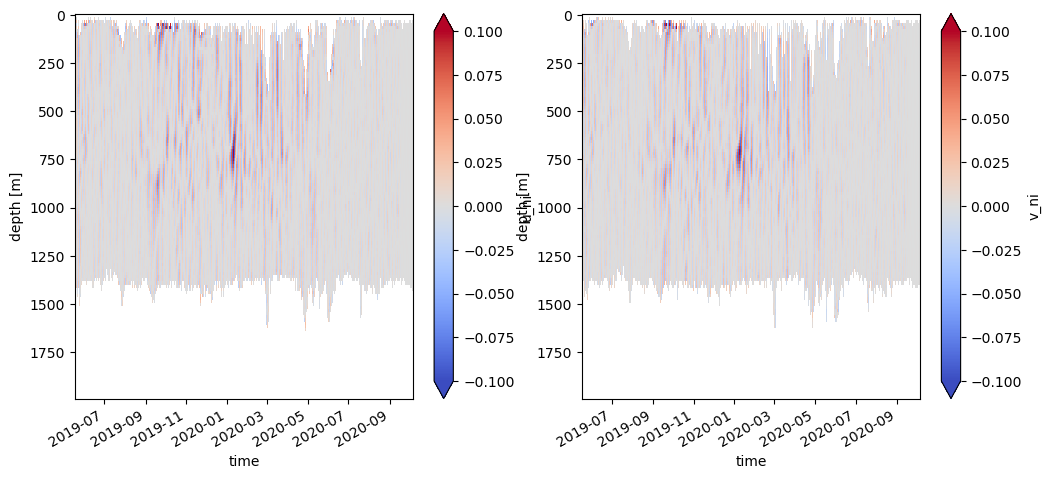

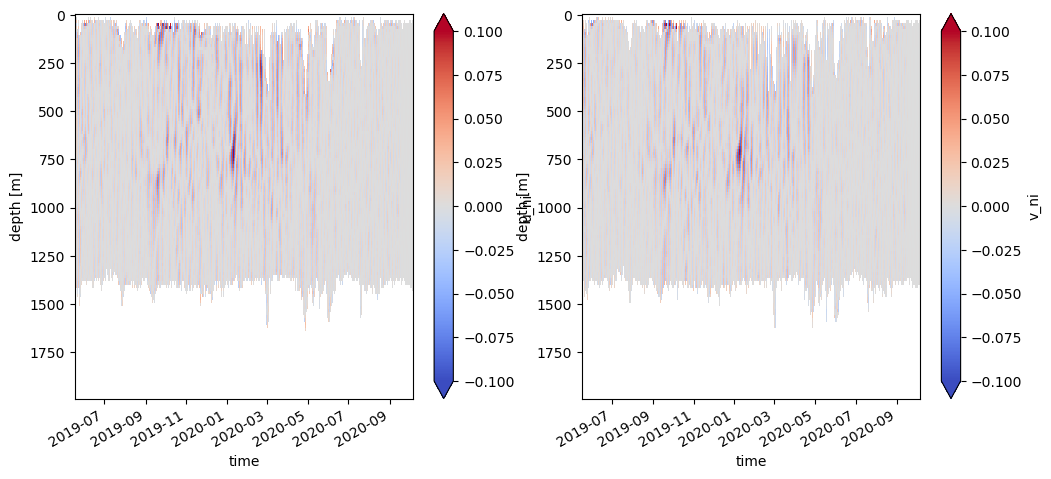

In [10]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121)
pl.plot_uv(ds,'u',fig,ax)

ax = fig.add_subplot(122)
pl.plot_uv(ds,'v',fig,ax)

fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121)
pl.plot_uv(ds,'u_ni',fig,ax,vmax=0.1)

ax = fig.add_subplot(122)
pl.plot_uv(ds,'v_ni',fig,ax,vmax=0.1)

fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121)
pl.plot_uv(ds_cubic,'u_ni',fig,ax,vmax=0.1)

ax = fig.add_subplot(122)
pl.plot_uv(ds_cubic,'v_ni',fig,ax,vmax=0.1)

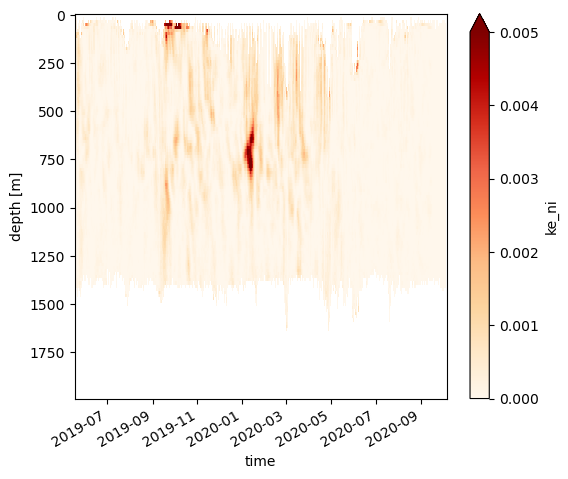

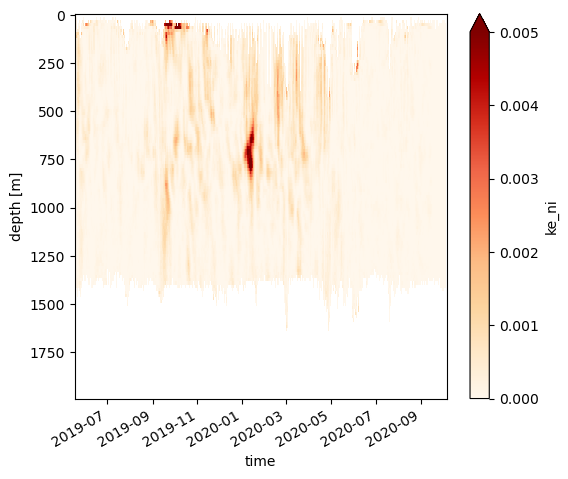

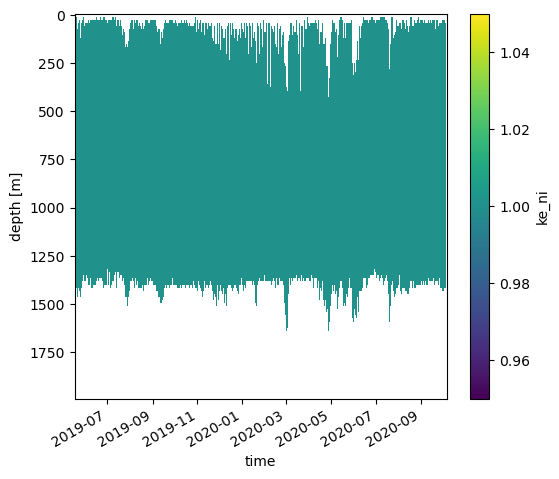

In [11]:
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)
pl.plot_uv(ds,'ke_ni',fig,ax,cmap='OrRd',vmax=0.005)


fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)
pl.plot_uv(ds_cubic,'ke_ni',fig,ax,cmap='OrRd',vmax=0.005)


fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)
(ds['ke_ni']/ds_cubic['ke_ni']).plot(ax=ax,yincrease=False)